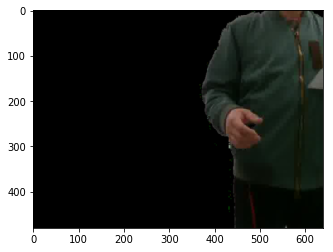

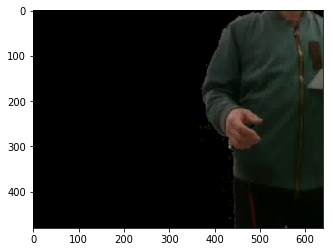

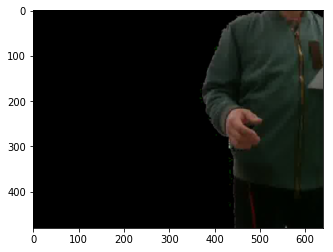

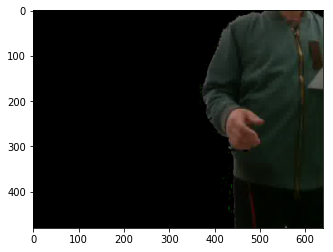

KeyboardInterrupt: 

In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt 
import scipy.misc
import cv2
import statistics

# data path 
depth_data_path = "/mnt/data/yxchen/gesture-datasets/ems/data/subject01_machine_recovery_3gps_2pairs/depth/"
rgb_data_path = "/mnt/data/yxchen/gesture-datasets/ems/data/subject01_machine_recovery_3gps_2pairs/rgb/"

# store path
no_bg_data_path = "/mnt/data/jarvislam1999//subject01_machine_recovery_3gps_2pairs/tmp/"

# get all subdirectories that contain images (frames)
depth_data_subdirt = [d[0] for d in os.walk(depth_data_path)]
rgb_data_subdirt = [r[0] for r in os.walk(rgb_data_path)]
depth_data_subdirt = depth_data_subdirt[1:]
depth_data_subdirt.sort()
rgb_data_subdirt = rgb_data_subdirt[1:]
rgb_data_subdirt.sort()
iter_d = 0
# loop through all subdirts (a subdirt contains the frames of one gesture)
for subdirt in depth_data_subdirt:
    if (iter_d == 4):
        break
    #iter_d += 1
    
    if not os.path.isdir(subdirt.replace("depth/", "rgb/")):
        continue
    
    frames = os.listdir(subdirt)
    frames.sort()
    
    iter_f = 0
    # loop through each frame in a gesture
    for frame in frames:
        if (iter_f == 10):
            break
        #iter_f += 1
        # load the pixels of an depth image (a frame)
        depth_path = subdirt+'/'+frame
        depth_img = Image.open(depth_path, 'r')
        pixels_of_depth_img = np.array(depth_img.getdata())
        pixels_of_depth_img = np.reshape(pixels_of_depth_img, (480, 640, 3))
        #plt.imshow(pixels_of_depth_img, interpolation="none")
        #plt.show()
        
        
        # load the pixels of an rgb image (a frame)
        rgb_path = subdirt.replace("depth/", "rgb/")+'/'+frame
        
        rgb_img = Image.open(rgb_path, 'r')
        pixels_of_rgb_img = np.array(rgb_img.getdata())
        pixels_of_rgb_img = np.reshape(pixels_of_rgb_img, (480, 640, 3))

        
        # remove background
        #temp_matrix_1 = (pixels_of_depth_img!=[0, 0, 0])
        temp_matrix_1 = np.greater(pixels_of_depth_img, [10,10,10])
        pixels_no_bg_img = pixels_of_rgb_img * temp_matrix_1
        #plt.imshow(pixels_no_bg_img, interpolation="none")
        #plt.show()
        
        r = 1  # range of neighboring black pixel to look for
        # Make the gray part of each frame black
        for row in range(len(pixels_no_bg_img)):
            for col in range(len(pixels_no_bg_img[row])):                      
                if (all([abs(x - statistics.median(pixels_no_bg_img[row][col])) <= 10 for x in pixels_no_bg_img[row][col]])\
                    and all([x >= 100 for x in pixels_no_bg_img[row][col]])):
                    #pixels_no_bg_img[row][col] = [0,0,0]
                    for i in range(max(0, row - r), min(row+r, len(pixels_no_bg_img))):
                        for j in range(max(0, col-r), min(col+r, len(pixels_no_bg_img[i]))):
                            if (np.count_nonzero(pixels_no_bg_img[i][j]) == 0):
                                pixels_no_bg_img[row][col] = [0,0,0]
                           
        #print(pixels_no_bg_img[280][420])
        
        # save image 
        pixels_no_bg_img = np.array(pixels_no_bg_img, dtype=np.uint8)
        
        # Apply edge smoothing (barely)
        pixels_no_bg_img = cv2.GaussianBlur(pixels_no_bg_img, (5,5), 0)
        #pixels_no_bg_img = cv2.medianBlur(pixels_no_bg_img, 7)
        
        # view image
        plt.imshow(pixels_no_bg_img, interpolation="none")
        plt.show()
        
        no_bg_img = Image.fromarray(pixels_no_bg_img)
        
        if not os.path.isdir(no_bg_data_path+depth_path.replace(depth_data_path, "").replace(frame, "")):
            print("create new dir: " + no_bg_data_path+depth_path.replace(depth_data_path, "").replace(frame, ""))                 
            os.system("mkdir " + no_bg_data_path+depth_path.replace(depth_data_path, "").replace(frame, ""))
        no_bg_img.save(no_bg_data_path+depth_path.replace(depth_data_path, ""))
        